In [2]:
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
X_train = np.load('data/SFEW_2/Train/train_aug2.npy')
y_train = np.load('data/SFEW_2/Train/train_aug2_labels.npy')
X_val = np.load('data/SFEW_2/Val/val.npy')
y_val = np.load('data/SFEW_2/Val/val_labels.npy')

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

print X_train.shape
print y_train.shape
print X_val.shape
print y_val.shape

(1751, 160, 160, 3)
(1751,)
(431, 160, 160, 3)
(431,)


In [4]:
tf.reset_default_graph()

In [5]:
def cnn(X, y, is_training):
    conv1 = tf.layers.conv2d(X, 64, 5, strides=(2,2), padding='same', activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(conv1, training=is_training)
    pool1 = tf.layers.max_pooling2d(bn1, pool_size=2, strides=2)
    conv2 = tf.layers.conv2d(pool1, 64, 5, strides=(2,2), padding='same', activation=tf.nn.relu)
    bn2 = tf.layers.batch_normalization(conv2, training=is_training)
    pool2 = tf.layers.max_pooling2d(bn2, pool_size=2, strides=2)
#     conv3 = tf.layers.conv2d(pool2, 64, 3, strides=(1,1), padding='same', activation=tf.nn.relu)
#     bn3 = tf.layers.batch_normalization(conv3, training=is_training)
#     pool3 = tf.layers.max_pooling2d(bn2, pool_size=4, strides=4)
    pool3_flat = tf.reshape(pool2, [-1, 6400])
    dense4 = tf.layers.dense(pool3_flat, units=128, activation=tf.nn.relu)
    y_out = tf.layers.dense(dense4, units=7)
    return y_out

X = tf.placeholder(tf.float32, [None, 160,160,3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = cnn(X, y, is_training)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,7),logits=y_out))
optimizer = tf.train.AdamOptimizer(5e-4)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(loss)

In [6]:
session = tf.Session()

session.run(tf.global_variables_initializer())

In [7]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    
    correct_prediction = tf.equal(tf.argmax(predict, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    train_indices = np.arange(Xd.shape[0])
    np.random.shuffle(train_indices)

    variables = [loss_val, correct_prediction, accuracy]
    
    training_now = training is not None
    if training_now:
        variables[-1] = training

    iter_cnt = 0

    for e in xrange(epochs):
        correct = 0
        losses = []
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indices[start_idx:start_idx+batch_size]



            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now}
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]

            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            output = session.run(variables,feed_dict=feed_dict)
            loss = output[0]
            corr = output[1]
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += float(np.sum(corr))

            # print every now and then
            if (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,float(np.sum(corr))/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print total_correct
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()

Iteration 0: with minibatch training loss = 3.13 and accuracy of 0.22
Iteration 20: with minibatch training loss = 1.78 and accuracy of 0.33
0.234151913192
Epoch 1, Overall loss = 2.44 and accuracy of 0.234


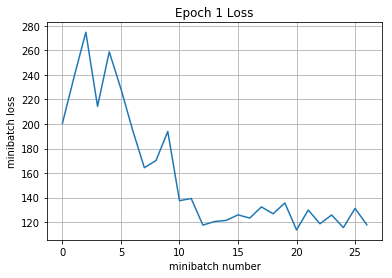

Iteration 40: with minibatch training loss = 1.47 and accuracy of 0.56
0.399771559109
Epoch 2, Overall loss = 1.54 and accuracy of 0.4


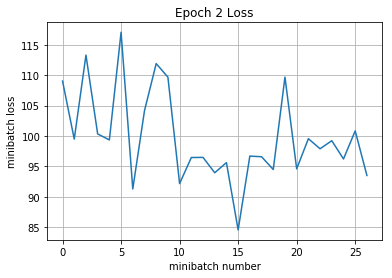

Iteration 60: with minibatch training loss = 1.04 and accuracy of 0.69
Iteration 80: with minibatch training loss = 1.06 and accuracy of 0.61
0.551684751571
Epoch 3, Overall loss = 1.2 and accuracy of 0.552


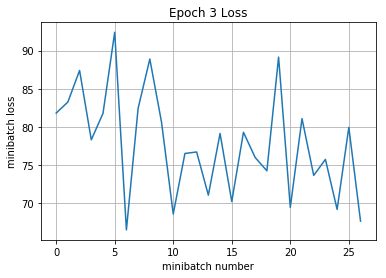

Iteration 100: with minibatch training loss = 1.08 and accuracy of 0.62
0.683038263849
Epoch 4, Overall loss = 0.885 and accuracy of 0.683


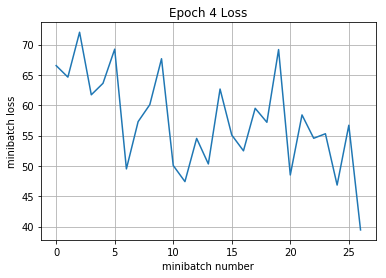

Iteration 120: with minibatch training loss = 0.589 and accuracy of 0.84
0.821245002856
Epoch 5, Overall loss = 0.589 and accuracy of 0.821


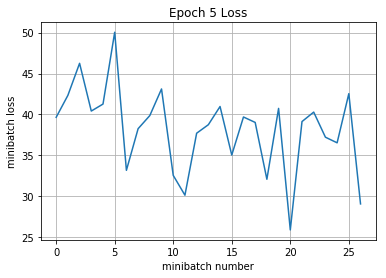

Iteration 140: with minibatch training loss = 0.515 and accuracy of 0.84
Iteration 160: with minibatch training loss = 0.436 and accuracy of 0.91
0.896059394632
Epoch 6, Overall loss = 0.39 and accuracy of 0.896


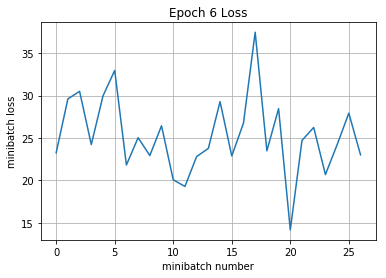

Iteration 180: with minibatch training loss = 0.254 and accuracy of 0.94
0.929754426042
Epoch 7, Overall loss = 0.278 and accuracy of 0.93


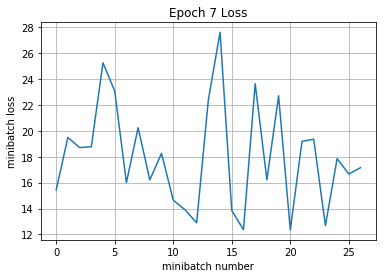

In [8]:
with tf.device('/gpu:0'):
    run_model(session, y_out, loss, X_train, y_train, 
              epochs=7, batch_size=64, print_every=20, training = train_step, plot_losses=True)

In [10]:
run_model(session, y_out, loss, X_val, y_val, 1, batch_size=5, print_every=20)

Iteration 0: with minibatch training loss = 0.84 and accuracy of 0.6
Iteration 20: with minibatch training loss = 3.41 and accuracy of 0
Iteration 40: with minibatch training loss = 1.71 and accuracy of 0.4
Iteration 60: with minibatch training loss = 3.34 and accuracy of 0.2
Iteration 80: with minibatch training loss = 2.41 and accuracy of 0.4
0.2343387471
Epoch 1, Overall loss = 2.55 and accuracy of 0.234


In [11]:
tf.reset_default_graph()

In [12]:
def cnn2(X, y, is_training):
    conv1 = tf.layers.conv2d(X, 64, 9, strides=(4,4), padding='same', activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(conv1, training=is_training)
    pool1 = tf.layers.max_pooling2d(bn1, pool_size=2, strides=2)
    pool3_flat = tf.reshape(pool1, [-1, 25600])
    dense4 = tf.layers.dense(pool3_flat, units=128, activation=tf.nn.relu)
    y_out = tf.layers.dense(dense4, units=7)
    return y_out

X = tf.placeholder(tf.float32, [None, 160,160,3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = cnn2(X, y, is_training)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,7),logits=y_out))
optimizer = tf.train.AdamOptimizer(5e-4)

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(loss)

Iteration 0: with minibatch training loss = 3 and accuracy of 0.16
0.234151913192
Epoch 1, Overall loss = 2.79 and accuracy of 0.234


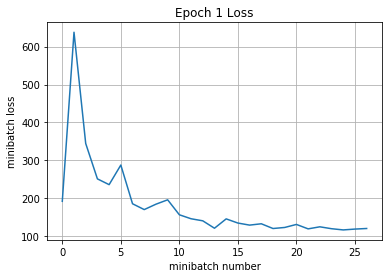

Iteration 50: with minibatch training loss = 1.47 and accuracy of 0.5
0.394631639063
Epoch 2, Overall loss = 1.58 and accuracy of 0.395


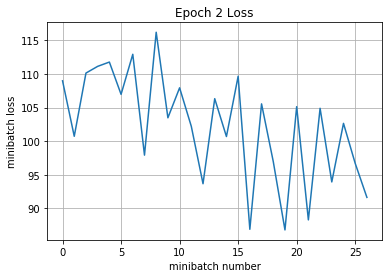

0.583095374072
Epoch 3, Overall loss = 1.14 and accuracy of 0.583


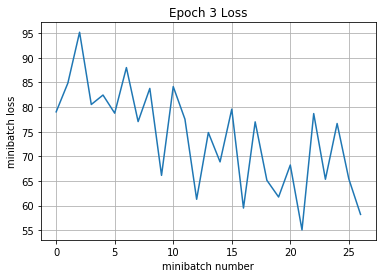

Iteration 100: with minibatch training loss = 0.63 and accuracy of 0.83
0.750999428898
Epoch 4, Overall loss = 0.729 and accuracy of 0.751


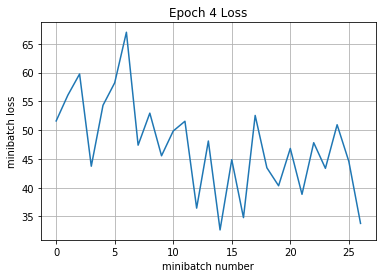

0.853226727584
Epoch 5, Overall loss = 0.45 and accuracy of 0.853


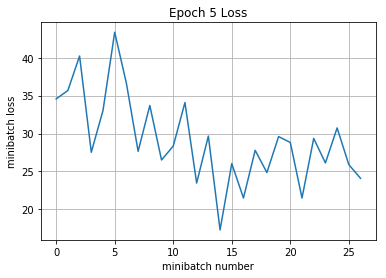

Iteration 150: with minibatch training loss = 0.294 and accuracy of 0.92
0.90919474586
Epoch 6, Overall loss = 0.297 and accuracy of 0.909


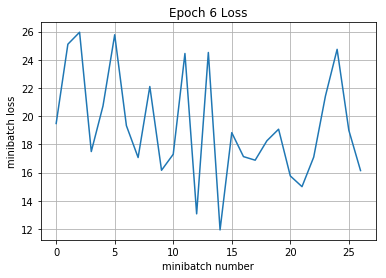

0.939463163906
Epoch 7, Overall loss = 0.211 and accuracy of 0.939


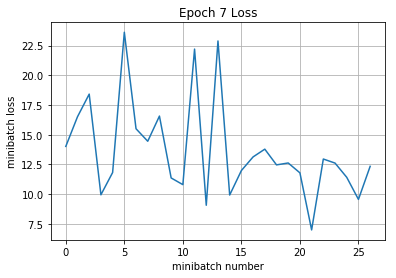

In [13]:
session = tf.Session()

session.run(tf.global_variables_initializer())

run_model(session, y_out, loss, X_train, y_train, 
          epochs=7, batch_size=64, print_every=50, training = train_step, plot_losses=True)

In [15]:
run_model(session, y_out, loss, X_val, y_val, 1, batch_size=5, print_every=20)

Iteration 0: with minibatch training loss = 2.96 and accuracy of 0.2
Iteration 20: with minibatch training loss = 2.52 and accuracy of 0.2
Iteration 40: with minibatch training loss = 2.63 and accuracy of 0.4
Iteration 60: with minibatch training loss = 4.17 and accuracy of 0
Iteration 80: with minibatch training loss = 0.894 and accuracy of 0.8
0.248259860789
Epoch 1, Overall loss = 3.21 and accuracy of 0.248
